In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq
import string
from nltk.corpus import stopwords

In [4]:
##Download dataset
import requests
path = "https://www.gutenberg.org/files/1661/1661-0.txt"
r = requests.get(path, allow_redirects=True)
open('1661-0.txt', 'wb').write(r.content)
#print('corpus length:', len(text))
text = open("/content/1661-0.txt").read().lower()

In [5]:
print("Length of dataset:",len(text))

Length of dataset: 581533


In [6]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [7]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [8]:
unique_words

array(['000', '1', '10', ..., 'zest', 'zigzag', 'œuvre'], dtype='<U18')

In [9]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['the', 'project', 'gutenberg', 'ebook', 'of']
the


In [10]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [11]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [12]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['the', 'project', 'gutenberg', 'ebook', 'of']
the


## Model

In [13]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

## Model Training:

In [16]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=28, epochs=5, shuffle=True).history

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/5
3704/3704 [==============================] - 538s 144ms/step - loss: 6.8020 - accuracy: 0.1369 - val_loss: 9.3723 - val_accuracy: 0.0700
Epoch 2/5
3704/3704 [==============================] - 530s 143ms/step - loss: 6.4204 - accuracy: 0.1629 - val_loss: 9.4102 - val_accuracy: 0.0815
Epoch 3/5
3704/3704 [==============================] - 537s 145ms/step - loss: 6.0206 - accuracy: 0.1956 - val_loss: 9.7274 - val_accuracy: 0.0663
Epoch 4/5
3704/3704 [==============================] - 536s 145ms/step - loss: 5.6183 - accuracy: 0.2329 - val_loss: 9.8944 - val_accuracy: 0.0736
Epoch 5/5
3704/3704 [==============================] - 543s 147ms/step - loss: 5.2324 - accuracy: 0.2730 - val_loss: 10.2546 - val_accuracy: 0.0828


In [17]:
model.save('Autocomplete.h5')
pickle.dump(history, open("history.pickle", "wb"))

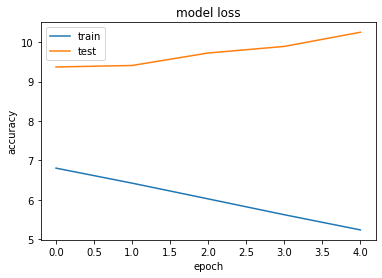

In [18]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

Incresasing the number of epochs will help to reduce Validation loss.

In [20]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)    

def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]    

## Prediction:

In [39]:
print("Inference:")
question =  "Good"
print("correct sentence: ",question)
seq = " ".join(tokenizer.tokenize(question.lower())[0:5])
print("Sequence: ",seq)
print("Next possible words: ", predict_completions(seq, 5))

Inference:
correct sentence:  Good
Sequence:  good
good
Next possible words:  ['night', 'and', 'left', 'made', 'money']


In [40]:
print("Inference:")
question =  "Its Good to see"
print("correct sentence: ",question)
seq = " ".join(tokenizer.tokenize(question.lower())[0:5])
print("Sequence: ",seq)
print("Next possible words: ", predict_completions(seq, 5))

Inference:
correct sentence:  Its Good to see
Sequence:  its good to see
its
good
to
see
Next possible words:  ['holmes', 'him', 'so', 'the', 'she']


## Conclusion:

To increase the accuracy, the number epochs need to be incresed further to get apt results.